In [ ]:
# files = [
#   'floor1_meetingroom_co2meter_co2_ppm.csv',
#   'floor1_meetingroom_co2meter_humidity_perc.csv',
#   'floor1_meetingroom_co2meter_temp_c.csv',

#   'floor2_meetingroom_co2meter_co2_ppm.csv',
#   'floor2_meetingroom_co2meter_humidity_perc.csv',
#   'floor2_meetingroom_co2meter_temp_c.csv',

#   'floor1_office_heater_consumption_j.csv',
#   'floor1_office_heater_power_w.csv',
#   'floor1_office_co2meter_co2_ppm.csv',
#   'floor1_office_co2meter_humidity_perc.csv',
#   'floor1_office_co2meter_temp_c.csv'
# ]

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay

def readFloor(prefix: str, ind: int):
  def getPath(name: str) -> str:
    return f"../data/{prefix}_co2meter_{name}"

  co2 = pd.read_csv(getPath('co2_ppm.csv'))
  humidity = pd.read_csv(getPath('humidity_perc.csv'))
  temp = pd.read_csv(getPath('temp_c.csv'))
  print('min', min(co2.size, humidity.size, temp.size))
  print('max', max(co2.size, humidity.size, temp.size))
  merged = pd.merge(co2, humidity, on = 'Time') #outter join? Leave unknown values? "introduce missing values in the features"
  #"allow yourself a reject option"? "what features do the classifiers find most informative?" learning curve? Explainable AI?
  #how many players in your training set can you get a good performance? (Hint; make a learning curve)
  #extremes in data
  merged = pd.merge(merged, temp, on = 'Time')
  merged['ind'] = ind
  columns = ['co2', 'humidity', 'temp']
  merged.columns = ['Time'] + columns + ['ind']
  merged['combined'] = merged[columns].apply(list, axis = 1)
  merged = merged.drop(columns = columns)
  columns = ['ind', 'combined']
  merged['combined'] = merged[columns].apply(list, axis = 1)
  merged = merged.drop(columns = ['ind'])
  print(merged.head())
  return merged

f1meetingRoom = readFloor("floor1_meetingroom", 0)
f1office = readFloor("floor1_office", 1)
f2meetingRoom = readFloor("floor2_meetingroom", 2)

min 238900
max 271436
                  Time                   combined
0  2023-12-19 13:40:00  [0, [451.0, 49.6, 18.24]]
1  2023-12-19 13:42:00  [0, [451.0, 49.6, 18.24]]
2  2023-12-19 13:43:00  [0, [445.0, 49.6, 18.28]]
3  2023-12-19 13:45:00  [0, [445.0, 49.6, 18.28]]
4  2023-12-19 13:48:00  [0, [445.0, 49.6, 18.28]]
min 286780
max 322000
                  Time                   combined
0  2023-12-19 13:37:00  [1, [646.0, 43.1, 21.52]]
1  2023-12-19 13:39:00  [1, [646.0, 43.1, 21.58]]
2  2023-12-19 13:40:00  [1, [715.0, 43.2, 21.55]]
3  2023-12-19 13:42:00  [1, [715.0, 43.1, 21.55]]
4  2023-12-19 13:43:00  [1, [715.0, 43.1, 21.52]]
min 656884
max 701372
                  Time                                 combined
0  2023-02-03 15:27:00  [2, [895.0, 47.900000000000006, 19.66]]
1  2023-02-03 15:29:00                [2, [845.0, 48.0, 19.71]]
2  2023-02-03 15:30:00                [2, [845.0, 48.0, 19.71]]
3  2023-02-03 15:32:00                [2, [845.0, 48.0, 19.71]]
4  2023-02-03 

In [94]:
merged = pd.merge(f1meetingRoom, f1office, on = 'Time')
merged = pd.merge(merged, f2meetingRoom, on = 'Time')
columns = ['f1meetingRoom', 'f1office', 'f2meetingRoom']
merged.columns = ['Time'] + columns
merged['combined'] = merged[columns].apply(list, axis = 1)
merged = merged.drop(columns = columns)
merged['Time'] = pd.to_datetime(merged['Time'])

def getTime(x):
  return [
      #x.timestamp() // 60,
   # (x - pd.Timestamp(year = x.year, month = 1, day = 1)).total_seconds() // 60,
          x.year, x.month, x.day, x.hour, x.minute, x.weekday()
          ]
# merged['Time'] = (merged['Time'].astype(int) // 10**9) // 60 #timestamp in minutes. Leave entries with timestamp existing for all floors.
merged['Time'] = merged['Time'].apply(getTime)

print('merged.size', merged.size)
print(merged.head())
print(merged['combined'][0])
flattened = merged.explode('combined', ignore_index = True)
print(flattened.head())

merged.size 57646
                        Time  \
0  [2023, 12, 19, 13, 40, 1]   
1  [2023, 12, 19, 13, 43, 1]   
2  [2023, 12, 19, 13, 45, 1]   
3  [2023, 12, 19, 13, 48, 1]   
4  [2023, 12, 19, 13, 49, 1]   

                                            combined  
0  [[0, [451.0, 49.6, 18.24]], [1, [715.0, 43.2, ...  
1  [[0, [445.0, 49.6, 18.28]], [1, [715.0, 43.1, ...  
2  [[0, [445.0, 49.6, 18.28]], [1, [715.0, 43.1, ...  
3  [[0, [445.0, 49.6, 18.28]], [1, [650.0, 43.2, ...  
4  [[0, [404.0, 49.5, 18.31]], [1, [650.0, 43.2, ...  
[[0, [451.0, 49.6, 18.24]], [1, [715.0, 43.2, 21.55]], [2, [797.0, 49.3, 20.38]]]
                        Time                   combined
0  [2023, 12, 19, 13, 40, 1]  [0, [451.0, 49.6, 18.24]]
1  [2023, 12, 19, 13, 40, 1]  [1, [715.0, 43.2, 21.55]]
2  [2023, 12, 19, 13, 40, 1]  [2, [797.0, 49.3, 20.38]]
3  [2023, 12, 19, 13, 43, 1]  [0, [445.0, 49.6, 18.28]]
4  [2023, 12, 19, 13, 43, 1]  [1, [715.0, 43.1, 21.52]]


In [95]:
labels = []
a = []
for x in flattened.to_numpy():
  # data.append([x[1][0], np.array(x[0] + x[1][1], dtype=np.float32)])
  labels.append(x[1][0])
  a.append(np.array(x[0] + x[1][1], dtype=np.float32))

labels = np.array(labels)
data = np.array(a)
print("labels.shape", labels.shape)
print("data.shape", data.shape)

labels.shape (86469,)
data.shape (86469, 9)


In [96]:
xTrain, xTest, yTrain, yTest = train_test_split(data, labels, random_state = 0, test_size = 0.2)

In [97]:
#Dummy classifier
clf = DummyClassifier(strategy = 'most_frequent', random_state = 0)
dummyCvScores = cross_val_score(clf, xTrain, yTrain, cv = 5)
print(dummyCvScores)
clf.fit(xTrain, yTrain)
clf.score(xTest, yTest)

[0.33364655 0.33364655 0.33364655 0.33371883 0.33371883]


0.3319648432982537

In [81]:
print('Training Data Samples: ', len(xTrain))
print('Testing Data Samples: ', len(xTest))
pipe = Pipeline([
                ('scaler', StandardScaler()), #pretty bad without scaling
                 ('SVM',
                  SVC(random_state = 0)
                  )
                 ])
paramGrid = {
    'SVM__C': [1, 10],
    #           'gamma': [0.05, 0.1, 'scale', 'auto'],
              'SVM__kernel': ['linear', 'rbf']
    }
grid = GridSearchCV(
    pipe, paramGrid, n_jobs = -1, refit = True, verbose = 3)
grid.fit(xTrain, yTrain)
print(grid.best_params_)
svmModel = grid.best_estimator_
yPred = svmModel.predict(xTest)
accuracy = accuracy_score(yTest, yPred)
print('SVM Accuracy: ', accuracy)

Training Data Samples:  69175
Testing Data Samples:  17294
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............decision__max_depth=5;, score=0.764 total time=   0.2s
[CV 3/5] END decision__criterion=gini, decision__max_depth=5;, score=0.764 total time=   0.2s
[CV 3/5] END decision__criterion=entropy, decision__max_depth=20;, score=0.972 total time=   0.4s
[CV 5/5] END decision__class_weight=None, decision__max_depth=20;, score=0.968 total time=   0.6s
[CV 1/5] END ............decision__max_depth=20;, score=0.971 total time=   0.3s
[CV 5/5] END decision__max_depth=5, decision__min_samples_split=10;, score=0.767 total time=   0.2s
[CV 2/5] END logistic__learning_rate=adaptive, logistic__penalty=l2;, score=nan total time=   0.0s
[CV 1/5] END .........SVM__C=1, SVM__kernel=rbf;, score=0.902 total time= 4.8min
[CV 3/5] END ............decision__max_depth=20;, score=0.970 total time=   0.3s
[CV 2/5] END ............decision__max_depth=20;, score=0.965 total 

In [82]:
pipe = Pipeline([
                ('scaler', StandardScaler()), #pretty bad without scaling
                 ('KNN',
                  KNeighborsClassifier()
                  )
                 ])
grid = GridSearchCV(pipe,
                    param_grid = {
                        'KNN__n_neighbors': [3, 10],
                        'KNN__weights': ['uniform', 'distance'],
                        },
                    n_jobs = -1, cv = 5, refit = True, verbose = 1)
grid.fit(xTrain, yTrain)
print(grid.best_params_)
knnModel = grid.best_estimator_
yPred = knnModel.predict(xTest)
knnAccuracy = accuracy_score(yTest, yPred)
print('KNN accuracy: ', knnAccuracy)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'KNN__n_neighbors': 3, 'KNN__weights': 'distance'}
KNN accuracy:  0.9476697120388574


In [92]:
pipe = Pipeline([
                ('scaler', StandardScaler()),
                 ('logistic',
                  # LogisticRegression(max_iter = 150, tol = 1e-3, random_state = 0)
                  SGDClassifier(loss = "log_loss", max_iter = 1000, tol = 1e-3, random_state = 0)
                  )
                 ])
#pipe.fit(Xtrain, yTrain).score(Xtest, yTest)
param_grid = {
        # 'logistic__fit_intercept': [True, False],
    'logistic__learning_rate': ['constant', 'adaptive'], 
    'logistic__eta0': [0.01],
    'logistic__penalty': ['l1', 'l2'],
        # 'logistic__C': [0.1, 0.5, 1.0, 2.0],
    # 'logistic__class_weight': [None, 'balanced'],
    # 'logistic__max_iter': [150, 1000],
}
grid = GridSearchCV(pipe, n_jobs = -1, param_grid = param_grid, cv = 5,
                            scoring = 'accuracy', refit = True, verbose = 3)
grid.fit(xTrain, yTrain)
print(grid.best_params_)
print("grid.score(xTest, yTest)", grid.score(xTest, yTest))
be = grid.best_estimator_
yPred = be.predict(xTest)
accuracyEst = accuracy_score(yTest, yPred)
print("accuracyEst", accuracyEst)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'logistic__eta0': 0.01, 'logistic__learning_rate': 'constant', 'logistic__penalty': 'l1'}
grid.score(xTest, yTest) 0.6817971550826877
accuracyEst 0.6817971550826877


In [85]:
scaler = StandardScaler()
xTrainScaled = scaler.fit_transform(xTrain)
xValScaled = scaler.transform(xTest)
model = SGDClassifier(loss = 'log_loss', max_iter = 1, warm_start = True, random_state = 0)
nEpochs = 1000
trainAccuracies = []
valAccuracies = []
for epoch in range(nEpochs):
    indices = np.arange(xTrainScaled.shape[0])
    np.random.shuffle(indices)
    XtrainShuffled = xTrainScaled[indices]
    yTrainShuffled = yTrain[indices]    
    model.partial_fit(XtrainShuffled, yTrainShuffled, classes = [0, 1, 2])    
    yTrainPred = model.predict(xTrainScaled)
    yValPred = model.predict(xValScaled)    
    trainAccuracies.append(accuracy_score(yTrain, yTrainPred))
    valAccuracies.append(accuracy_score(yTest, yValPred))

[CV 5/5] END logistic__learning_rate=adaptive, logistic__penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END logistic__eta0=0.01, logistic__learning_rate=constant, logistic__penalty=l1;, score=0.697 total time=   0.4s
[CV 3/5] END logistic__learning_rate=adaptive, logistic__penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END logistic__learning_rate=adaptive, logistic__penalty=l2;, score=nan total time=   0.0s
[CV 3/5] END logistic__eta0=0.01, logistic__learning_rate=constant, logistic__penalty=l2;, score=0.686 total time=   0.4s
[CV 3/5] END logistic__eta0=0.01, logistic__learning_rate=constant, logistic__penalty=l2;, score=0.686 total time=   0.4s
[CV 2/5] END logistic__learning_rate=adaptive, logistic__penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END logistic__learning_rate=adaptive, logistic__penalty=l2;, score=nan total time=   0.0s
[CV 1/5] END logistic__eta0=0.01, logistic__learning_rate=constant, logistic__penalty=l2;, score=0.678 total time=   0.4s
[CV 1/5] END logi

KeyboardInterrupt: 

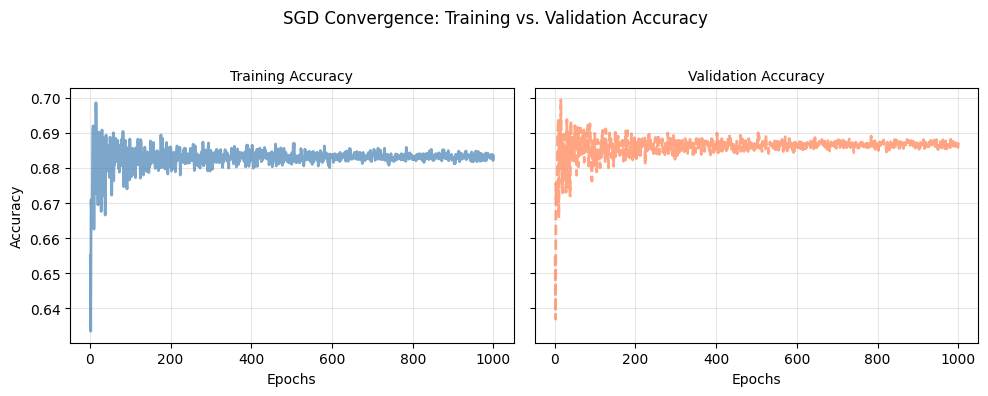

In [69]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4), sharey = True)
axes[0].plot(range(1, nEpochs + 1), trainAccuracies, color='steelblue', linestyle='-', linewidth=2, alpha=0.7)
axes[0].set_title('Training Accuracy', fontsize=10)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].grid(alpha=0.3)
axes[1].plot(range(1, nEpochs + 1), valAccuracies, color='coral', linestyle='--', linewidth=2, alpha=0.7)
axes[1].set_title('Validation Accuracy', fontsize=10)
axes[1].set_xlabel('Epochs')
axes[1].grid(alpha=0.3)
fig.suptitle('SGD Convergence: Training vs. Validation Accuracy', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# import pandas as pd

# mean_scores = np.array(grid.cv_results_["mean_test_score"])
# mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# mean_scores = mean_scores.max(axis=0)
# mean_scores = pd.DataFrame(
#     mean_scores.T, index=N_FEATURES_OPTIONS, columns=reducer_labels
# )
# ax = mean_scores.plot.bar()
# ax.set_title("Comparing feature reduction techniques")
# ax.set_xlabel("Reduced number of features")
# ax.set_ylabel("Digit classification accuracy")
# ax.set_ylim((0, 1))
# ax.legend(loc="upper left")
# plt.show()

In [102]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
                 ('decision',
                    DecisionTreeClassifier(min_impurity_decrease = 0.0, random_state = 0)
                  )
                 ])
param_grid = {
    # 'decision__criterion': ['gini', 'entropy'],
    # 'decision__class_weight': [None, 'balanced'],
    # 'decision__max_depth': [5, 20],
    # 'decision__min_samples_split': [2, 10]
}
grid = GridSearchCV(pipe, n_jobs = -1, param_grid = param_grid, cv = 5,
                            scoring = 'accuracy', refit = True, verbose = 3)
grid.fit(xTrain, yTrain)
print(grid.best_params_)
print("grid.score(xTest, yTest)", grid.score(xTest, yTest))
be = grid.best_estimator_
yPred = be.predict(xTest)
accuracyEst = accuracy_score(yTest, yPred)
print("accuracyEst", accuracyEst)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}
grid.score(xTest, yTest) 0.977333179137273
accuracyEst 0.977333179137273


Confusion matrix, without normalization
[[5667    6   78]
 [  13 5592  136]
 [  44  115 5643]]
Normalized confusion matrix
[[0.99 0.   0.01]
 [0.   0.97 0.02]
 [0.01 0.02 0.97]]


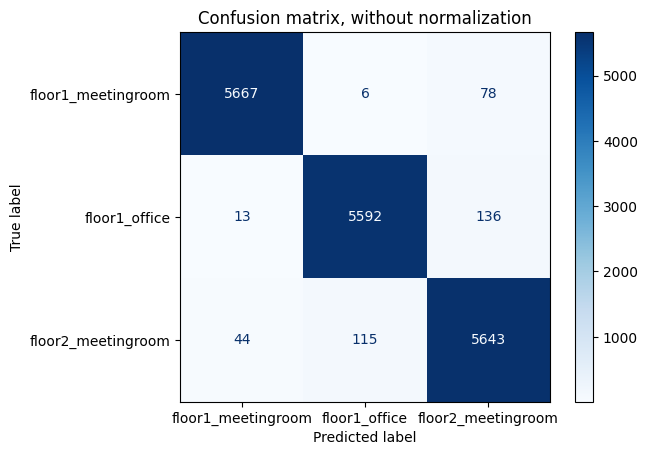

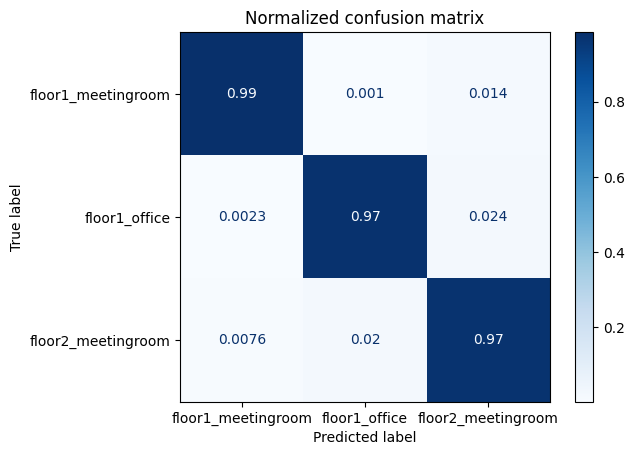

In [104]:
class_names = ['floor1_meetingroom', 'floor1_office', 'floor2_meetingroom']
np.set_printoptions(precision = 2)
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        be,
        xTest,
        yTest,
        display_labels = class_names,
        cmap = plt.cm.Blues,
        normalize = normalize,
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
plt.show()